In [10]:
"""
PS2 – Question 3 (a)

This script generates a random graph from the G(n,m) model
with average degree c = 2m/n. It computes the size of the
largest connected component and compares the result with
the theoretical prediction S = 1 - exp(-cS).
"""

import math
import random
from collections import defaultdict


# This function finds the size of the largest connected component
# using a Union-Find (disjoint set) structure.

def find_largest_component(n, edges):
    
    parent = list(range(n))
    rank = [0] * n

    # Find with path compression
    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    # Union by rank
    def union(x, y):
        rx, ry = find(x), find(y)
        if rx == ry:
            return
        if rank[rx] < rank[ry]:
            rx, ry = ry, rx
        parent[ry] = rx
        if rank[rx] == rank[ry]:
            rank[rx] += 1

    # Merge components according to edges
    for u, v in edges:
        union(u, v)

    # Count sizes of components
    size = defaultdict(int)
    for i in range(n):
        size[find(i)] += 1

    return max(size.values())


# This function generates a random graph G(n,m)
# by sampling m distinct edges uniformly at random.

def generate_gnm(n, m):
    
    edges = set()
    
    # Keep sampling random pairs until we have m edges
    while len(edges) < m:
        u = random.randrange(n)
        v = random.randrange(n)
        
        if u != v:
            # Store edges in sorted order since graph is undirected
            if u > v:
                u, v = v, u
            edges.add((u, v))
    
    return list(edges)


# Runs one simulation:
# computes m from c and returns largest component fraction

def run_trial(n, c):
    
    # In G(n,m), average degree is c = 2m/n
    m = int(round(c * n / 2))
    
    edges = generate_gnm(n, m)
    
    largest_size = find_largest_component(n, edges)
    
    return largest_size / n


# Solves the theoretical equation S = 1 - exp(-cS)
# using simple fixed-point iteration

def solve_S(c, tol=1e-10):
    
    if c <= 1.0:
        return 0.0

    S = 0.5  # initial guess
    
    for _ in range(10000):
        S_new = 1 - math.exp(-c * S)
        if abs(S_new - S) < tol:
            return S_new
        S = S_new
    
    return S


# Main test block

if __name__ == "__main__":
    random.seed(42)  # add this for reproducibility
    
    n = 1_000_000
    c = 2 * math.log(2)
    
    print("Running simulation for n =", n)
    
    sim_fraction = run_trial(n, c)
    theory_fraction = solve_S(c)
    
    print("Simulation fraction:", sim_fraction)
    print("Theory fraction:", theory_fraction)
    print("Difference:", abs(sim_fraction - theory_fraction))

Running simulation for n = 1000000
Simulation fraction: 0.500986
Theory fraction: 0.5
Difference: 0.0009860000000000424


n =     1,000   E[M] =        692.8   SD =    26.38   CV = 0.038072
n =    10,000   E[M] =      6,932.5   SD =    83.04   CV = 0.011979
n =   100,000   E[M] =     69,315.8   SD =   260.78   CV = 0.003762
n = 1,000,000   E[M] =    693,152.7   SD =   829.81   CV = 0.001197


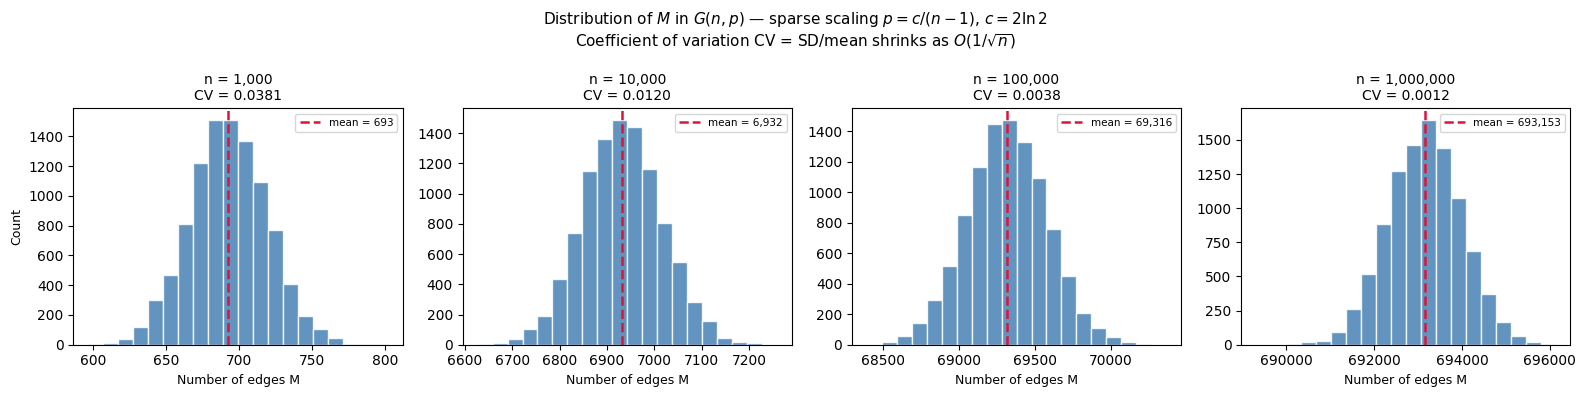

In [15]:
"""
Question 3 (b)

This script illustrates the concentration of the number of edges M
in the G(n,p) model under sparse scaling p = c/(n-1).

For increasing values of n, we simulate M ~ Binomial(N_edges, p)
and plot its distribution. The goal is to show that relative
fluctuations of M shrink as n grows, explaining why G(n,p)
and G(n,m) are asymptotically equivalent.
"""

import numpy as np
import matplotlib.pyplot as plt


# Average degree parameter
c = 2 * np.log(2)

# Different graph sizes
n_values = [1000, 10000, 100000, 1000000]

# Number of simulations per n
n_trials = 10000

# Create one subplot per n
fig, axes = plt.subplots(1, len(n_values), figsize=(16, 4))

for ax, n in zip(axes, n_values):

    # Sparse regime scaling: expected degree = c
    p = c / (n - 1)

    # Total possible number of undirected edges
    N_edges = n * (n - 1) // 2

    # In G(n,p), number of edges M follows Binomial(N_edges, p)
    M_samples = np.random.binomial(N_edges, p, size=n_trials)

    # Compute mean, std, and coefficient of variation
    mean_M = np.mean(M_samples)
    std_M  = np.std(M_samples)
    cv     = std_M / mean_M

    # Plot histogram
    ax.hist(M_samples, bins=20, color='steelblue', edgecolor='white', alpha=0.85)

    # Mark the mean with a vertical line
    ax.axvline(mean_M, color='crimson', linewidth=1.8, linestyle='--', label=f'mean = {mean_M:,.0f}')

    # Title shows n and CV so the concentration argument is visible
    ax.set_title(f"n = {n:,}\nCV = {cv:.4f}", fontsize=10)
    ax.set_xlabel("Number of edges M", fontsize=9)
    ax.legend(fontsize=7.5)

    # Print summary to console as well
    print(f"n = {n:>9,}   E[M] = {mean_M:>12,.1f}   SD = {std_M:>8,.2f}   CV = {cv:.6f}")

# Label y-axis only on the leftmost panel
axes[0].set_ylabel("Count", fontsize=9)

plt.suptitle(
    r"Distribution of $M$ in $G(n,p)$ — sparse scaling $p = c/(n-1)$, $c = 2\ln 2$"
    "\nCoefficient of variation CV = SD/mean shrinks as $O(1/\\sqrt{n})$",
    fontsize=11
)

plt.tight_layout()
plt.savefig("3b.png", dpi=150, bbox_inches="tight")
plt.show()

n =     1,000   E[M] =        693.1   CV = 0.037956
n =    10,000   E[M] =      6,931.5   CV = 0.012010
n =   100,000   E[M] =     69,314.7   CV = 0.003798
n = 1,000,000   E[M] =    693,147.2   CV = 0.001201


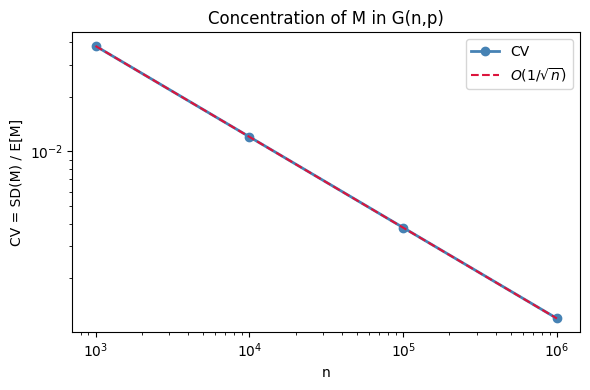

In [7]:
"""
Question 3 (c)

This script verifies numerically that the coefficient of variation
of M in G(n,p) shrinks as O(1/sqrt(n)), explaining why G(n,p) and
G(n,m) are asymptotically equivalent for large n.
"""

import math
import matplotlib.pyplot as plt


# Average degree parameter
c = 2 * math.log(2)

# Values of n to check
n_values = [1000, 10000, 100000, 1000000]


# For each n, compute the theoretical mean and CV of M
for n in n_values:

    p  = c / (n - 1)
    mu = n * (n - 1) / 2 * p
    cv = math.sqrt(mu * (1 - p)) / mu

    print(f"n = {n:>9,}   E[M] = {mu:>12,.1f}   CV = {cv:.6f}")


# Plot CV as a function of n to show it decays as O(1/sqrt(n))
cv_values = []

for n in n_values:
    p  = c / (n - 1)
    mu = n * (n - 1) / 2 * p
    cv = math.sqrt(mu * (1 - p)) / mu
    cv_values.append(cv)


fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(n_values, cv_values, color='steelblue', marker='o', linewidth=2, label='CV')

# O(1/sqrt(n)) reference line
ref = [cv_values[0] * math.sqrt(n_values[0] / n) for n in n_values]
ax.plot(n_values, ref, color='crimson', linestyle='--', linewidth=1.5, label=r'$O(1/\sqrt{n})$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel('CV = SD(M) / E[M]')
ax.set_title('Concentration of M in G(n,p)')
ax.legend()

plt.tight_layout()
plt.savefig("3c_cv.png", dpi=150, bbox_inches='tight')
plt.show()

